In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

In [2]:
import itertools as it
from collections import Counter, defaultdict, deque

In [3]:

import json
import time
import itertools as it
import sys
sys.path.append('lib')
from analysis_utils import *


In [4]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import ri2py
%load_ext rpy2.ipython

In [101]:
df1 = pd.read_csv('data/human/0.3/mouselab-mdp.csv')
df2 = pd.read_csv('data/human/0.4/mouselab-mdp.csv')
df2.pid += (pdf1.pid.max() + 1)
pdf1 = pd.read_csv('data/human/0.3/participants.csv')
pdf2 = pd.read_csv('data/human/0.4/participants.csv')
pdf2.pid += (pdf1.pid.max() + 1)
df = pd.concat([df1, df2]).reset_index()
pdf = pd.concat([pdf1, pdf2]).reset_index()

# df = pd.read_csv('data/human/0.4/mouselab-mdp.csv')
# pdf = pd.read_csv('data/human/0.4/participants.csv')

df.trial_index = df.trial_index.astype(int)
df.trial_i = df.trial_i.astype(int)
df['version'] = list(pdf.version.loc[df.pid])
df['info_cost'] = list(pdf.info_cost.loc[df.pid])
df['PR_type'] = list(pdf.PR_type.loc[df.pid])

from toolz.curried import *
from ast import literal_eval
df['clicks'] = df.queries.apply(literal_eval).apply(
    lambda x: np.array(x['click']['state']['target'])
)
df['click_times'] = df.queries.apply(literal_eval).apply(
    lambda x: np.array(x['click']['state']['time'])
)
df.action_times = df.action_times.apply(literal_eval)
df['n_click'] = df.clicks.apply(len)
df.delays = df.delays.apply(literal_eval)

pdf['time'] = df.groupby('pid').time_elapsed.max() / 60000
pdf.score = df.groupby('pid').score.sum()

In [102]:
# pdf = pd.read_csv('data/human/0.1/participants.csv')
# identifiers = pd.read_csv('data/human_raw/0.1/identifiers.csv')
# pdf = pdf.join(identifiers.set_index('pid'))
# sys.path.append('bin')
# from compensation import Compensator
# comp = Compensator()
# for i, row in pdf.iterrows():
#     comp.approve(row.assignment_id)
#     if row.bonus > 0:
#         comp.grant_bonus(row.worker_id, row.assignment_id, round(row.bonus, 2))

In [103]:
def before_first(row):
    try:
        a1 = row.action_times[0]
        return sum(row.click_times < a1)
    except:
        return None

df['early_click'] = df.apply(before_first, axis=1)

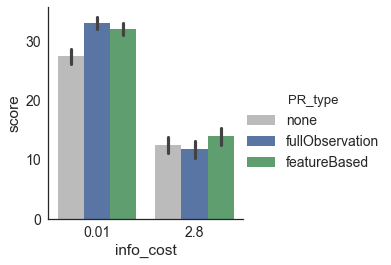

In [104]:
PALETTE = ['#bbbbbb'] + sns.palettes.SEABORN_PALETTES['deep']
sns.set_palette(PALETTE)
PR_ORDER = ['none', 'fullObservation', 'featureBased']

sns.factorplot('info_cost', 'score', hue='PR_type', data=df.query('version == 0.4'), 
               kind='bar', hue_order=PR_ORDER)

In [105]:
optimal = pd.read_csv('data/stimuli/exp1/optimal.csv', header=None)[0]
df['optimal'] = list(optimal.loc[df.trial_i])
df['regret'] = df.score - df.optimal

df['trial_mean'] = list(df.groupby('trial_i').score.mean().loc[df.trial_i])
df['centered_score'] = df.score - df.trial_mean

pi_star = pd.read_csv('data/stimuli/exp1/score_pi_star.csv', header=None)
pi_star.columns = [0.01, 1.60,2.80]
worst = pd.read_csv('data/stimuli/exp1/worst.csv', header=None)[0]

# (R-R_min)/(R_max-R_min)
r_min = worst.loc[df.trial_i].as_matrix()
df['pi_star'] = pi_star.stack()[df[['trial_i', 'info_cost']].as_matrix()].as_matrix()
r_max = df.optimal
r = df.score
df['relative_score'] = (r - r_min) / (r_max - r_min)

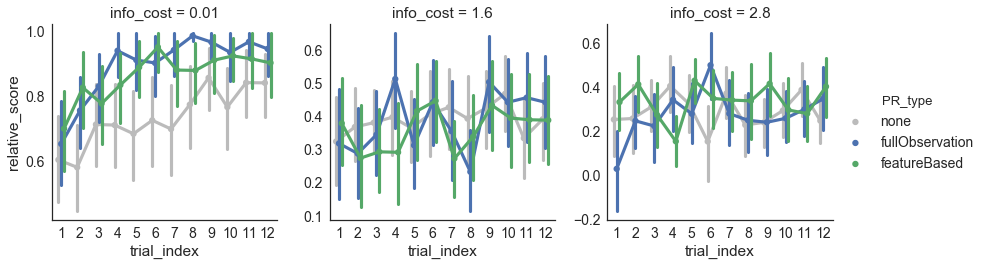

In [106]:
sns.factorplot('trial_index', 'relative_score', hue='PR_type', data=df, sharey=False,
               col='info_cost', 
               dodge=.3, markers='.', ci=95, estimator=np.mean,
               hue_order=PR_ORDER, palette=PALETTE)

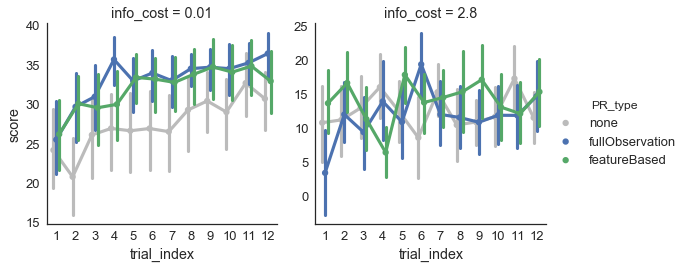

In [609]:
sns.factorplot('trial_index', 'score', hue='PR_type', data=df, sharey=False,
               col='info_cost', 
               dodge=.3, markers='.', ci=95, estimator=np.mean,
               hue_order=PR_ORDER, palette=PALETTE)

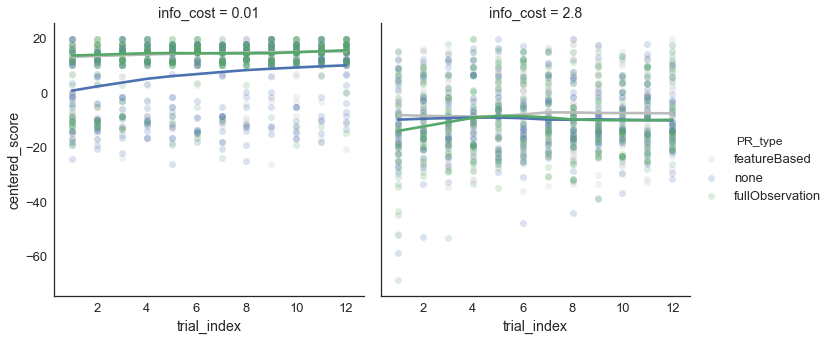

In [521]:
sns.lmplot('trial_index', 'centered_score', hue='PR_type', data=df, 
           lowess=True,
           scatter_kws=dict(alpha=0.2),
           col='info_cost')

In [382]:
# from pymc3 import *

# with Model():
#     glm.GLM.from_formula('score ~ PR_type * trial_index', data=df)
#     start = find_MAP()
#     step = NUTS(scaling=start)
#     trace = sample(2000, step)
    

# full = t['PR_type[T.fullObservation]']
# none = t['PR_type[T.none]']
# (none > 0).mean()

Optimization terminated successfully.
         Current function value: 2314.381831

/usr/local/lib/miniconda3/lib/python3.5/site-packages/pymc3/sampling.py:163: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')
  4%|▍         | 82/2000 [00:00<00:11, 173.13it/s]


         Iterations: 47
         Function evaluations: 55
         Gradient evaluations: 55


In [200]:
rdf = df2r(df.query('trial_index < 9 and trial_i < 9'), 
           ['info_cost', 'trial_index', 'score', 'pid'])
rdf['pr'] = 1
xrdf = df2r(xdf, 
           ['info_cost', 'trial_index', 'score', 'pid'])
xrdf['pr'] = 0
rdf = pd.concat([rdf, xrdf])

In [153]:
rdf = df2r(df, 
           ['info_cost', 'trial_index', 'score', 'n_click', 'pid', 'trial_i'])

In [169]:
%%R -i rdf
require(lme4)
require(car)
Anova(lmer('score ~ trial_index * pr + (1|pid)', 
           data=subset(rdf, info_cost >0)
                      ))

Analysis of Deviance Table (Type II Wald chisquare tests)

Response: score
                 Chisq Df Pr(>Chisq)    
trial_index    36.4900  1  1.534e-09 ***
pr              8.4216  1   0.003708 ** 
trial_index:pr  0.1836  1   0.668337    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [181]:
g = df.groupby('info_cost').score
g.agg(('mean', 'std'))

,mean,std
info_cost,,
0.01,33.781806,9.396062
1.60,15.625000,12.914835
2.80,11.814508,14.828723


In [203]:

print(rdf
 .query('trial_index == [1, 8]')
 .groupby(['info_cost', 'pr', 'trial_index'])
 .score
 .agg(('mean', 'std'))
)

                               mean        std
info_cost pr trial_index                      
0.01      0  1.0          16.855000  11.998510
             8.0          31.835714  12.315762
          1  1.0          27.916000  11.325721
             8.0          37.448571   6.686267
1.60      0  1.0          11.370000  12.067054
             8.0          17.520000  14.395672
          1  1.0           7.470588  13.950079
             8.0          20.127273   8.566574
2.80      0  1.0           6.083333  16.813754
             8.0          12.509091  16.528847
          1  1.0           6.000000  17.853953
             8.0          17.307692  12.894861


In [170]:
%%R -i rdf
summary(lm('score ~ trial_index * pr', 
           data=subset(rdf, info_cost > 0)
                      ))


Call:
lm(formula = "score ~ trial_index * pr", data = subset(rdf, info_cost > 
    0))

Residuals:
    Min      1Q  Median      3Q     Max 
-62.205 -11.886   0.268  13.696  30.714 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     11.8592     1.5552   7.625 5.95e-14 ***
trial_index      1.1091     0.3097   3.581 0.000359 ***
pr               2.8507     2.3049   1.237 0.216470    
trial_index:pr   0.1645     0.4586   0.359 0.719920    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.08 on 939 degrees of freedom
Multiple R-squared:  0.03961,	Adjusted R-squared:  0.03654 
F-statistic: 12.91 on 3 and 939 DF,  p-value: 2.868e-08



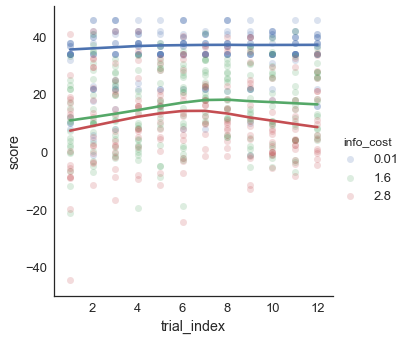

In [26]:
sns.lmplot('trial_index', 'score', hue='info_cost', data=df, lowess=True,
          scatter_kws=dict(alpha=0.2))

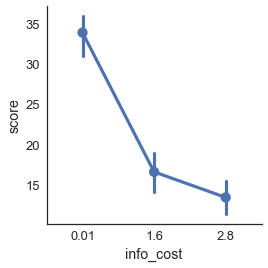

In [101]:
import seaborn as sns
sns.factorplot('info_cost', 'score', data=pdf)

In [53]:
df = pd.read_csv('data/human/0.1/mouselab-mdp.csv')
pdf = pd.read_csv('data/human/0.1/participants.csv')
# identifiers = pd.read_csv('data/human_raw/0.1/identifiers.csv')


In [14]:
pdf['bonus'] = (df.groupby('pid').score.apply(lambda x: x.sample(1).iloc[0]) * 0.05)
pdf['score'] = df.groupby('pid').score.mean()
pdf['worker_id'] = identifiers.worker_id

In [36]:
pdf['pay'] = pdf.bonus + 1
x = pdf[['worker_id', 'pay']].dropna()
x = x.rename(columns={'worker_id': 'amt_worker_id', 'pay': 'bonus'})
x['completion_code'] = 'lemur0530'
x['status'] = 'owed'

In [55]:
import sqlite3
conn = sqlite3.connect('/Users/fred/Projects/whoops_yall/participants.db')
x.to_sql(name='legit_worker', con=conn, if_exists='replace', index=False)
# assignment = (pd.read_sql_query('SELECT * from turkdemo', conn)
#  .set_index('workerid')
#  .assignmentid
# )
# df['assignment_id'] = list(assignment[df.amt_worker_id])
# df['index'] = df['index'].astype(int)
# df = df.set_index('index')
# submitted = df.query("status == 'submitted'")

,action_times,actions,correct,delays,path,queries,questions,responses,rt,score,time_elapsed,trial_index,trial_i,trial_type,view_history,pid
0,"[11887, 25236, 48932]","[u'right', u'right', u'down']",NaN,"[1, 3, 0]","[1, 2, 6, 11]","{u'mouseover': {u'state': {u'target': [], u'ti...",NaN,NaN,"[11886, 11075, 19882]",-0.4,280083,1.0,5.0,mouselab-mdp,NaN,0
1,"[32378, 37522, 40140]","[u'down', u'down', u'right']",NaN,"[2, 0, 0]","[1, 5, 9, 17]","{u'mouseover': {u'state': {u'target': [], u'ti...",NaN,NaN,"[32378, 1241, 1952]",19.6,336411,2.0,7.0,mouselab-mdp,NaN,0
2,"[29324, 33651, 36526]","[u'left', u'left', u'down']",NaN,"[2, 0, 0]","[1, 4, 8, 15]","{u'mouseover': {u'state': {u'target': [], u'ti...",NaN,NaN,"[29323, 650, 2218]",4.4,390717,3.0,1.0,mouselab-mdp,NaN,0
3,"[37357, 40132, 41956]","[u'right', u'right', u'up']",NaN,"[0, 0, 0]","[1, 2, 6, 10]","{u'mouseover': {u'state': {u'target': [], u'ti...",NaN,NaN,"[37356, 891, 1191]",9.2,440150,4.0,10.0,mouselab-mdp,NaN,0
4,"[14388, 21204, 23100]","[u'right', u'right', u'up']",NaN,"[4, 0, 0]","[1, 2, 6, 10]","{u'mouseover': {u'state': {u'target': [], u'ti...",NaN,NaN,"[14388, 1331, 1220]",29.2,491767,5.0,2.0,mouselab-mdp,NaN,0
5,"[25832, 30633, 32361]","[u'up', u'up', u'right']",NaN,"[1, 0, 3]","[1, 3, 7, 13]","{u'mouseover': {u'state': {u'target': [], u'ti...",NaN,NaN,"[25831, 1968, 1072]",-2.2,543841,6.0,6.0,mouselab-mdp,NaN,0
6,"[15584, 17436, 18940]","[u'left', u'left', u'down']",NaN,"[0, 0, 0]","[1, 4, 8, 15]","{u'mouseover': {u'state': {u'target': [], u'ti...",NaN,NaN,"[15584, 167, 846]",32.0,592249,7.0,0.0,mouselab-mdp,NaN,0
7,"[17103, 19624, 21128]","[u'up', u'up', u'left']",NaN,"[0, 0, 0]","[1, 3, 7, 12]","{u'mouseover': {u'state': {u'target': [], u'ti...",NaN,NaN,"[17102, 723, 814]",27.4,640931,8.0,9.0,mouselab-mdp,NaN,0
8,"[17388, 19740, 21597]","[u'down', u'down', u'right']",NaN,"[0, 0, 0]","[1, 5, 9, 17]","{u'mouseover': {u'state': {u'target': [], u'ti...",NaN,NaN,"[17387, 817, 1196]",11.6,692757,9.0,11.0,mouselab-mdp,NaN,0
9,"[15789, 20861, 22381]","[u'right', u'right', u'up']",NaN,"[3, 0, 0]","[1, 2, 6, 10]","{u'mouseover': {u'state': {u'target': [], u'ti...",NaN,NaN,"[15788, 390, 841]",26.0,753165,10.0,3.0,mouselab-mdp,NaN,0


In [58]:
df = pd.read_sql_query('SELECT * from legit_worker', conn)
# df = df.replace('submitted', 'paid')
df

,index,amt_worker_id,completion_code,status,bonus
0,1.0,A201BS5OHBGQGM,wing0524,paid,3.5000
1,2.0,A8KX1HFH8NE2Q,wing0524,paid,3.0000
2,4.0,A3EU2ZIKRJTLQD,wing0524,paid,2.0000
3,5.0,A1MV2B8I02QVOE,wing0524,paid,2.0000
4,6.0,A1DCKRRPA4AWVD,wing0524,paid,0.4000
5,7.0,A2VSEW6K2UJQTG,wing0524,paid,1.0000
6,9.0,A2DLSR4447FB2Q,wing0524,paid,3.0000
7,10.0,A2QQY4S73JO639,wing0524,paid,3.0000
8,11.0,A18E16UFE351U6,wing0524,paid,3.0000
9,12.0,A11Z6BR15AJXJ7,lemur0530,owed,1.9800


,amt_worker_id,bonus,completion_code,status
0,A11Z6BR15AJXJ7,1.9800,lemur0530,owed
1,A1JYOZ111S9MIR,2.7600,lemur0530,owed
2,A1MUEKEQQVROE7,1.9600,lemur0530,owed
3,A1SKJ8SKCAY4WK,0.7400,lemur0530,owed
4,A1UY2W2FL9CWN,2.6945,lemur0530,owed
5,A1XTRYSSOR598O,2.5500,lemur0530,owed
6,A1ZB84ZGCAD7H0,1.6000,lemur0530,owed
8,A2Q1YS118AO2BP,2.8920,lemur0530,owed
9,A3424ZUN4F0OII,2.6920,lemur0530,owed
10,A3CUQS1UJ49MZB,2.0920,lemur0530,owed


In [40]:
(pdf.bonus + 1.00) / pdf.time * 60

0      4.968664
1      2.954287
2     27.147337
3      2.471610
4     11.292334
5      9.479708
6     10.058768
7           NaN
8      6.633564
9      7.735384
10    13.241202
11     6.965883
12    10.984038
13     3.630295
14          NaN
15     9.597362
dtype: float64

In [35]:
pdf['time'] = (df.groupby('pid').time_elapsed.max() / 60000)

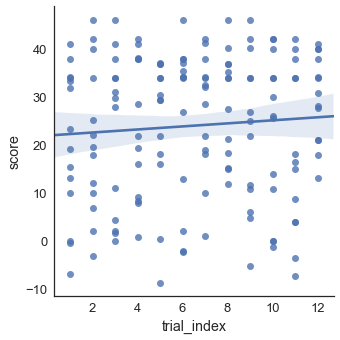

In [17]:
sns.lmplot('trial_index', 'score', data=df)

In [43]:
import json

with open('/Users/fred/Projects/mcrl/experiments/data/stimuli/exp1/mat_trials.json') as f:
    data = json.load(f)
    
data

[{'graph': {'0': {'actions': {'down': [5, 0],
     'left': [7, 0],
     'right': [3, 0],
     'up': [1, 0]},
    'path': None,
    'reward': 0},
   '1': {'actions': {'up': [2, 0]}, 'path': None, 'reward': 1},
   '2': {'actions': {}, 'path': None, 'reward': 2},
   '3': {'actions': {'right': [4, 0]}, 'path': None, 'reward': 3},
   '4': {'actions': {}, 'path': None, 'reward': 4},
   '5': {'actions': {'down': [6, 0]}, 'path': None, 'reward': 5},
   '6': {'actions': {}, 'path': None, 'reward': 6},
   '7': {'actions': {'left': [8, 0]}, 'path': None, 'reward': 7},
   '8': {'actions': {}, 'path': None, 'reward': 8}},
  'initialState': '0',
  'trialID': 0},
 {'graph': {'0': {'actions': {'down': [7, 0],
     'left': [10, 0],
     'right': [4, 0],
     'up': [1, 0]},
    'path': None,
    'reward': 0},
   '1': {'actions': {'up': [2, 0]}, 'path': None, 'reward': 1},
   '10': {'actions': {'left': [11, 0]}, 'path': None, 'reward': 10},
   '11': {'actions': {'left': [12, 0]}, 'path': None, 'reward': 

In [49]:
def get_paths(graph):
    """The sequences of actions and states that lead to each state."""

    state_paths = {}
    action_paths = {}
    def search(s, spath, apath):
        state_paths[s] = spath
        action_paths[s] = apath
        for a, (_, s1) in graph[s].items():
            search(s1, spath + [s1], apath + [a])
    search('0', ['0'], [])
    return {'state_paths': state_paths, 'action_paths': action_paths}



{'action_paths': {'0': [],
  '1': ['up'],
  '2': ['up', 'up'],
  '3': ['right'],
  '4': ['right', 'right'],
  '5': ['down'],
  '6': ['down', 'down'],
  '7': ['left'],
  '8': ['left', 'left']},
 'state_paths': {'0': ['0'],
  '1': ['0', '1'],
  '2': ['0', '1', '2'],
  '3': ['0', '3'],
  '4': ['0', '3', '4'],
  '5': ['0', '5'],
  '6': ['0', '5', '6'],
  '7': ['0', '7'],
  '8': ['0', '7', '8']}}

In [10]:

result = 

{'edgeDisplay': 'never',
 'graph': {'0': {'down': [0, '5'],
   'left': [0, '7'],
   'right': [0, '3'],
   'up': [0, '1']},
  '1': {'up': [0, '2']},
  '2': {},
  '3': {'right': [0, '4']},
  '4': {},
  '5': {'down': [0, '6']},
  '6': {},
  '7': {'left': [0, '8']},
  '8': {}},
 'initial': '0',
 'layout': {'0': [2, 2],
  '1': [2, 1],
  '2': [2, 0],
  '3': [3, 2],
  '4': [4, 2],
  '5': [2, 3],
  '6': [2, 4],
  '7': [1, 2],
  '8': [0, 2]},
 'stateClickCost': 0.05,
 'stateDisplay': 'click',
 'stateLabels': 'reward',
 'stateRewards': {'0': 0,
  '1': 1,
  '2': 2,
  '3': 3,
  '4': 4,
  '5': 5,
  '6': 6,
  '7': 7,
  '8': 8},
 'trial_i': 0}